# COMP 3359 Artificial Intelligent Application Group One
## Reimplementation of Neural Style Transfer Methods and Evaluation

### 1.The purpose of this notebook
This notebook presents the code for one out of three methods we implement on neural style transfer, namely the **Multiple-Style Per Model Method** .

In this notebook, we shall explain:
1. The overview of the neural style transfer method adopted by Gaty in the [paper](https://arxiv.org/abs/1508.06576) "A Neural Algorithm of Artistic Style" (2015)
2. The code we write based on this paper with detailed explanation and technical detail
3. Limitation analysis
---------------------------

### 2. Overview of this model
Before the emergence of neural networks, style transfer was defined as a process of texton (known as basic element of texture), which is mapping the texton to the target location.

The goal of it is to derive a generalization process from a sample texture to generate arbitrary new images with that texture. After the input image is given, the sampling function is defined to sample the small part of the input image’s feature and put the texture of the small part of the corresponding place. Finally, we will get a large texture based on each small part. It's just that the previous method was done in the image space. The authors adapt this idea and use the neural network (VGG16) to sample the style images. Here are the three parts of about this network
<center><img src='./notebookimages/network.jpg' width='100%'/></center>

    • Image encoder: consists of 3 convolution layers, it encodes the image into the feature map.
    • StyleBank layer: every filter bank will represent a style and each bank consists of several kernels (which represents a texton). Each texton will convolve with the feature map 
    • Image decoder: after putting each texton on the feature map, it will go through the decoder. And then we will get the styled output images
As you can see from the picture, this network consists of two branches:
    1. Encoder ———————————————————————————————> Decoder
    2. Encoder ——————> K(style layer) ————————> Decoder

Therefore, there are two loss fuction defined in the paper.
    
    O:  the output image
    I:  the input image
    Si: style image (for the i-th style)
    Oi: stylization result (for the i-th style) 
  At the auto-encoder branch:
<center><img src='./notebookimages/loss_01.jpg' width='60%'/></center>
Li (identity loss):  In this branch, we only need to make sure the image after going through the encoder and decoder do not have too much changes. Hence, it simply use MSE (Mean Square Error) between input image I and output image O to make sure the Li

  At the stylizing branch:
<center><img src='./notebookimages/loss_02.jpg' width='80%'/></center>
<center><img src='./notebookimages/loss_03.jpg' width='70%'/></center>

Lc (content loss):  Instead of directly computing the pixel value difference, we first extracts the features from the image using the pre-trained VGG16 and get the feature from 'block4_conv2'. And then we computes the feature (standed by F in upper formula) differences, which is the sum of square 2-norm of the pixel wise given by the upper formula.

Ls (style loss): Similarly, we first exatracts the features using the VGG16,but this time we want the feature more generlized, which means more superficial VGG layer outputs 'block1_conv2','block2_conv2','block3_conv2', 'block4_conv2'. 

Furthermore, we calculate the sum of the difference in gram matrix between style features and content features. The gram matrix denoted by 'G' in the formula is the the inner product among the channels in one particular feature maps, which could measures the correlation between different features in one feature maps.


Ltv(Oi) is the variation regularizer firstly used in Aly's [paper](https://ieeexplore.ieee.org/document/1510697).it reflects the image noise, so the image generated by this loss function can be kept smooth.
<center><img src='./notebookimages/tv_loss01.jpg' width='40%'/></center>

This image clearly shows the importance of Ltv
<center><img src='./notebookimages/tv_loss02.jpg' width='90%'/></center>
(a): the original image, (b): same image degaded by blur and poisson noise
(c): image goes through the encoder and decoder without the Ltv function 
(d): image goes through the encoder and decoder with the Ltv function

By changing the appropriate hyperparameter(𝜶,𝝱), we can modify the importance of content loss and style loss, thus generate images with more styled or more realistic to content images.


---------------------------

### 3. Implementation code
We first import necessary library. All of our implementations are based on tensorflow implementation. 

In [10]:
import tensorflow as tf
import numpy as np
from glob import glob
from skimage.transform import resize
from skimage.io import imread, imshow,imsave
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot as plt
import datetime
import time

The Hyperparameter are given below. 
Several empty arrays are initilized to keep tracking of the noise through out of the training.

In [2]:
### Hyper parameter
CONTENT_WEIGHT = 50
STYLE_WEIGHT = 250
REG_WEIGHT = 1e-6
BATCH_SIZE = 4

EPOCH = 300
T = 2

LR = 1e-2
optimizer= tf.keras.optimizers.Adam(learning_rate=LR)
t = 0

#content layer and style layer prepare for the VGG16 net
CONTENT_LAYERS = [
                'block4_conv2'
                ]



STYLE_LAYERS = ['block1_conv2',
                'block2_conv2',
                'block3_conv2', 
                'block4_conv2',
                ]


# Training loss track
CONTENT_LOSS = []
STYLE_LOSS = []
TOTAL_LOSS = []
VARIATION_LOSS = []
IDENTITY_LOSS= []

# load the image
img_shape=(None, 224, 224, 3)
content_shape=(None, 224, 224, 3)   #defult input shape of the VGG16 layer
style_imgs_path="./style/"
content_imgs_path="./content/"
style_imgs = glob(style_imgs_path + '*')
content_imgs = glob(content_imgs_path + '*')
n_styles = len(style_imgs)
n_content_imgs = len(content_imgs)


content_images = np.array([
        resize(
        imread(img_path),
        img_shape[1:]
        ) * 255 for img_path in content_imgs
    ])
            
style_images =[imread(img_path) for img_path in style_imgs]       
style_images = np.array([
        resize(
        e if e.shape[0] < e.shape[1] else np.transpose(e, [1, 0, 2]),
        content_shape[1:]
        ) * 255 for e in style_images
    ])


Here we visualize the content images, style images and noise images with different noise ratio

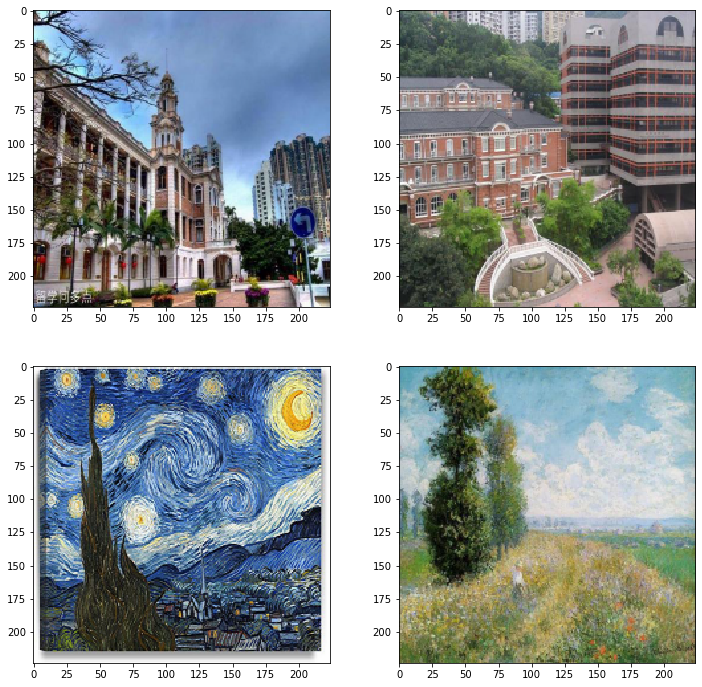

In [3]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(tf.cast(content_images[3],tf.int16))
fig.add_subplot(rows, columns, 2)
plt.imshow(tf.cast(content_images[2],tf.int16))
fig.add_subplot(rows, columns, 3)
plt.imshow(tf.cast(style_images[0],tf.int16))
fig.add_subplot(rows, columns, 4)
plt.imshow(tf.cast(style_images[1],tf.int16))
plt.show()

Same with the first model, We first build VGG-16 network pretrained on ImageNet 

Below is a graph of VGG 19 network, notice that the top full connection layer is removed as we do not need prediction result of the images.
The name of retrived feature map layers are exactly the same as those in hyper parameter section.
<center><img src='./notebookimages/6.png' width='50%'/></center>

In [4]:
vgg16 = VGG16(weights='imagenet')
output_s = [vgg16.get_layer(name).output for name in STYLE_LAYERS]
vgg16_s = Model(inputs=vgg16.input, outputs=output_s)
vgg16_s.trainable = False

output_c = [vgg16.get_layer(name).output for name in CONTENT_LAYERS]
vgg16_c = Model(inputs=vgg16.input, outputs=output_c)
vgg16_c.trainable = False

In the network package, we have all the nurtual network build inside. 
1.Encoder 2. StyleBank 3. Decoder

In [6]:
import networks
model = networks.StyleBank(len(style_images),len(content_images))
model.build(img_shape)
model.summary()

Model: "style_bank_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (encoder)          multiple                  100608    
_________________________________________________________________
decoder_1 (decoder)          multiple                  100227    
_________________________________________________________________
style 0Conv_1 (Conv2D)       multiple                  295168    
_________________________________________________________________
instance_normalization_22 (I multiple                  512       
_________________________________________________________________
style 0Conv_2 (Conv2D)       multiple                  590080    
_________________________________________________________________
instance_normalization_23 (I multiple                  512       
_________________________________________________________________
style 0Conv_3 (Conv2D)       multiple                 

Define the gram matrix for the style Loss calculation.
Gram matrix calculate the inner product of image.To do that it first transform the input image from the shape (B,H,W,C) to the shape (B,H*W,C). (as illustared in the below figure.)
<center><img src='./notebookimages/7.png' width='50%'/></center>

In [7]:
def gram_matrix(x):
        z = tf.reshape(x, [-1, tf.shape(x)[-1]])  # this makes z [H*W, C]
        z = tf.matmul(tf.transpose(z), z) / tf.cast(tf.shape(z)[0], dtype=tf.float32)
        return z

Here come to the training part.
<center><img src='./notebookimages/algo.jpg' width='50%'/></center>

The trainging process is direct follow the algorithm mentioned in the paper.


We first use the sample_train_batch to generrate some random number represents the content/style image.

And then, we use **tf.GradientTape** to record the feed forward passes through the network. It works like computing a recording of the feed forward pass through the model, and finally playing it backwards, in order to perform back propagation. This gradient tape records all the gradients happening through the network, and finally enables us to apply the training rule to update the current value of the parameters using these gradients by **apply_gradients** function.

After T + 1 we only update the Ecoder and Decoder params using the identity loss.


In [11]:
for i in range(EPOCH):
    for j in range(BATCH_SIZE):
        content_indexs = model.sample_train_batch(BATCH_SIZE, "content")
        style_indexs = model.sample_train_batch(BATCH_SIZE, "style")
        #two list to hold the branch index
        content_image_b = content_images[content_indexs]
        style_image_b = style_images[style_indexs]
        
        with tf.GradientTape() as tape:
            output_image_b = model.apply_style(content_image_b,style_indexs)
            output_image_g_features_b = [
                tf.map_fn(gram_matrix, feature) for feature in vgg16_s.call(output_image_b)
            ]

            style_g_features = [
                tf.map_fn(gram_matrix,feature) for feature in vgg16_s.call(tf.convert_to_tensor(style_image_b))
            ]
            
            output_image_features_b_s = vgg16_s.call(output_image_b)
            output_image_features_b_c = vgg16_c.call(output_image_b)
            style_features = vgg16_s.call(tf.convert_to_tensor(style_image_b))
            content_features_b = vgg16_c.call(tf.convert_to_tensor(content_image_b))

            

            style_loss = STYLE_WEIGHT* model.initialize_Ls(output_image_features_b_s,style_features)
            content_loss = CONTENT_WEIGHT * model.initialize_Lc(output_image_features_b_c,content_features_b)
            reg_loss = REG_WEIGHT * tf.math.reduce_mean(tf.image.total_variation(output_image_b))
            total_loss = content_loss + style_loss + reg_loss
            
            STYLE_LOSS.append(style_loss)
            CONTENT_LOSS.append(content_loss)
            VARIATION_LOSS.append(reg_loss)
            TOTAL_LOSS.append(total_loss)   
        gradients = tape.gradient(total_loss, model.trainable_variables)
        #!!!!!! check the varible
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


        t = t + 1
        if t == T + 1:
            t = 0
            with tf.GradientTape() as tape:
                identity_loss = model.initialize_Li(content_image_b)
                IDENTITY_LOSS.append(identity_loss)
            gradients = tape.gradient(identity_loss, model.trainable_variables)
            en_de_variables = []
            for x in gradients:
                if x != None:
                    en_de_variables.append(x)
            optimizer.apply_gradients(zip(en_de_variables, model.trainable_variables))

    if (i%10==0):
        print("Epoch: {}. Content loss: {}. Style loss: {} Variation loss{}.\n Total Loss: {}. ".format(i,CONTENT_LOSS[-1],STYLE_LOSS[-1],VARIATION_LOSS[-1],TOTAL_LOSS[-1]))
        img = resize(imread("./content/content01.jpg"), (900, 1080, 3)) * 255
        img = np.expand_dims(img, axis=0)
        imgr = model.apply_style(img,[style_indexs[0]])
        imgr = imgr.numpy()
        imgr = imgr[0] - imgr.min()
        imgr = imgr / imgr.max()
        imsave("./image_result/new_s{}c{}e{} styled{}.jpg".format(CONTENT_WEIGHT,STYLE_WEIGHT,i,style_indexs[0]),imgr)
        



Epoch: 0. Content loss: 15643822.0. Style loss: 288629792.0 Variation loss3.518425464630127.
 Total Loss: 304273600.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10. Content loss: 15239069.0. Style loss: 251035536.0 Variation loss2.6664369106292725.
 Total Loss: 266274608.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20. Content loss: 16047278.0. Style loss: 222094336.0 Variation loss2.5892088413238525.
 Total Loss: 238141616.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30. Content loss: 16807458.0. Style loss: 208763216.0 Variation loss2.8182520866394043.
 Total Loss: 225570672.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40. Content loss: 16368356.0. Style loss: 200404416.0 Variation loss3.0291812419891357.
 Total Loss: 216772768.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


KeyboardInterrupt: 

Notice that the it may take quite a long time during the trainging process. 
Hece, if you want you can choose the excute the follong cell to load the weight to the model. 
The complete training log can be seen in the [github notebook version](https://github.com/yyuezhi/HKU-COMP-3359-Group-I)

In [13]:
checkpoint_path =  "training_result3/cp-0247.ckpt"
model.load_weights(checkpoint_path)

Let's check the resultant images generated!

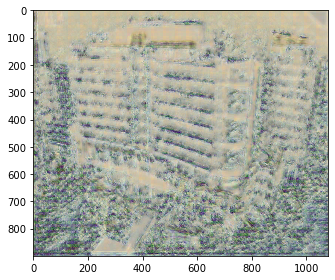

In [16]:
img = resize(imread("./content/content03.jpg"), (900, 1080, 3)) * 255
img = np.expand_dims(img, axis=0)
imgr = model.apply_style(img,[2])
imgr = imgr.numpy()
imgr = imgr[0] - imgr.min()
imgr = imgr / imgr.max()
imshow(imgr)

The loss function suggests that the training process has been fully converges and the break down of the total loss facilitates our analysis in the report.

Final loss data
Content_loss: tf.Tensor(16020742.0, shape=(), dtype=float32)
Style_loss: tf.Tensor(203606370.0, shape=(), dtype=float32)
Variation_loss: tf.Tensor(2.9518108, shape=(), dtype=float32)
STYLE LOSS BY LAYERS


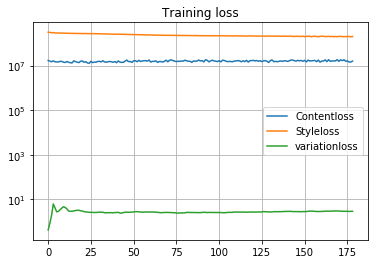

In [17]:
   
print("Final loss data")
print("Content_loss:",CONTENT_LOSS[-1])
print("Style_loss:",STYLE_LOSS[-1])
print("Variation_loss:",VARIATION_LOSS[-1])
    
print("STYLE LOSS BY LAYERS")

fig, ax = plt.subplots()
plt.title("Training loss")
ax.set_yscale('log')
ax.plot(CONTENT_LOSS, label='Contentloss')
ax.plot(STYLE_LOSS, label='Styleloss')
ax.plot(VARIATION_LOSS, label='variationloss')
plt.grid()
plt.legend()
plt.show()